# Preprocessing

In [10]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
%autoreload 2

In [12]:
import torch

In [13]:
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
import pandas as pd
from src.vfm.model.reg.gradient_boost import GradientBoost
from src.vfm.model.nn.swt_tft import SWTTFTModel
from src.utils.descriptive_utils import *
from src.vfm.model.physics.physics_informed import PhysicsInformedHybridModel, PhysicsModel
from src.utils import *
import matplotlib.pyplot as plt
import os

In [14]:
connection = Connection()
# Get client
client = connection.get_client()

In [57]:
df_all_wells = connection.get_data(client, wells=get_all_wells())

In [58]:
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test',
       'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm',
       'well_id'],
      dtype='object')

In [59]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [60]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_timeseries(df=df_all_wells)
len(df_all_wells_preprocessed)

Preprocessing well W06... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W08... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']


169

In [61]:
summarize_null(df_all_wells_preprocessed)

qo_mpfm      0
qg_mpfm      0
qw_mpfm      0
well_code    0
dhp          0
dht          0
whp          0
wht          0
choke        0
dcp          0
well_id      0
time_idx     0
dtype: int64

In [62]:
df_train, df_val, df_test = get_random_train_test_split_per_well_with_order_preserved(df=df_all_wells_preprocessed, test_size=0.2)
len(df_train), len(df_val), len(df_test)

(114, 14, 41)

In [63]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
model.fit(df=df_train, df_val=df_val)

[Validation] Residual RMSE = 0.6374


In [64]:
model.score_physics(df_test)

{'W06': {'qo': {'r2': 0.9347996185196847,
   'mae': 9.517120037185533,
   'rmse': 11.37848704199764},
  'qw': {'r2': -0.42347428371588536,
   'mae': 34.84492196654178,
   'rmse': 60.75757851948721},
  'qg': {'r2': 0.9042972905116301,
   'mae': 1418.2782463173521,
   'rmse': 1653.9252518788828},
  'wgr': {'r2': -11.459536956348563,
   'mae': 0.005114540755838629,
   'rmse': 0.009646972303680586}},
 'W08': {'qo': {'r2': 0.36727634517259966,
   'mae': 8.442136323281648,
   'rmse': 11.043990084801624},
  'qw': {'r2': -2.4640591768856623,
   'mae': 46.06958694611885,
   'rmse': 49.80258885352055},
  'qg': {'r2': 0.15067283918988328,
   'mae': 1096.0376224407664,
   'rmse': 1515.1214245792214},
  'wgr': {'r2': -2.0169332167553806,
   'mae': 0.011676716685390663,
   'rmse': 0.012215806802331001}}}

In [65]:
model.score_hybrid(df_test)

{'W06': {'qo': {'r2': 0.9347996185196847,
   'mae': 9.517120037185533,
   'rmse': 11.37848704199764},
  'qw': {'r2': 0.21611103803748555,
   'mae': 16.29804426617271,
   'rmse': 45.087163967530444},
  'qg': {'r2': 0.9619925991817763,
   'mae': 856.5963493161494,
   'rmse': 1042.2882615438036},
  'wgr': {'r2': -0.042776298134689306,
   'mae': 0.0012537867082879522,
   'rmse': 0.0027908446081524796}},
 'W08': {'qo': {'r2': 0.36727634517259955,
   'mae': 8.442136323281648,
   'rmse': 11.043990084801624},
  'qw': {'r2': -0.7569449398623209,
   'mae': 29.75274819505762,
   'rmse': 35.46813423815507},
  'qg': {'r2': 0.3796021266419113,
   'mae': 908.0906898701402,
   'rmse': 1294.926394683864},
  'wgr': {'r2': -0.4570035244706474,
   'mae': 0.008144083444801569,
   'rmse': 0.008489255572493184}}}

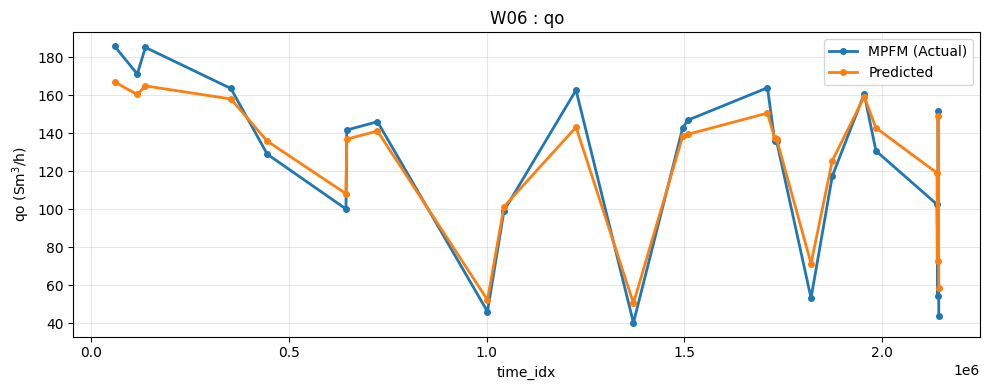

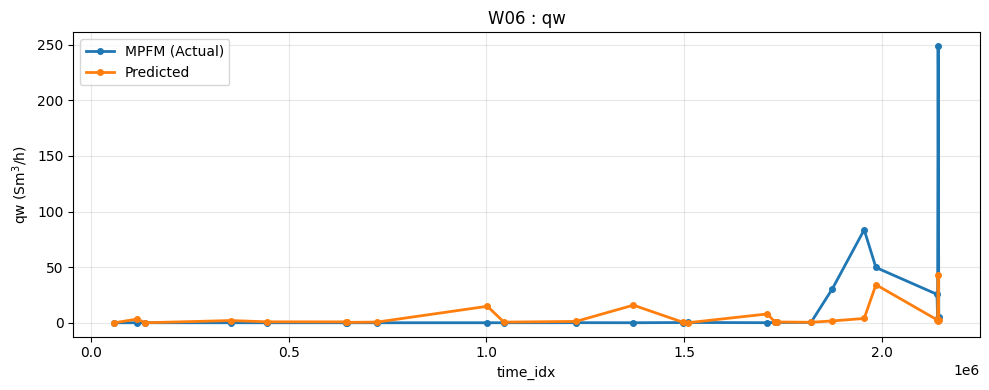

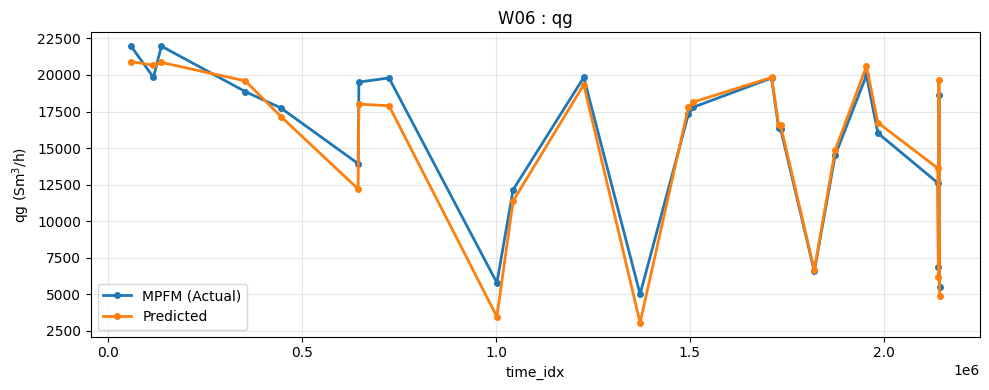

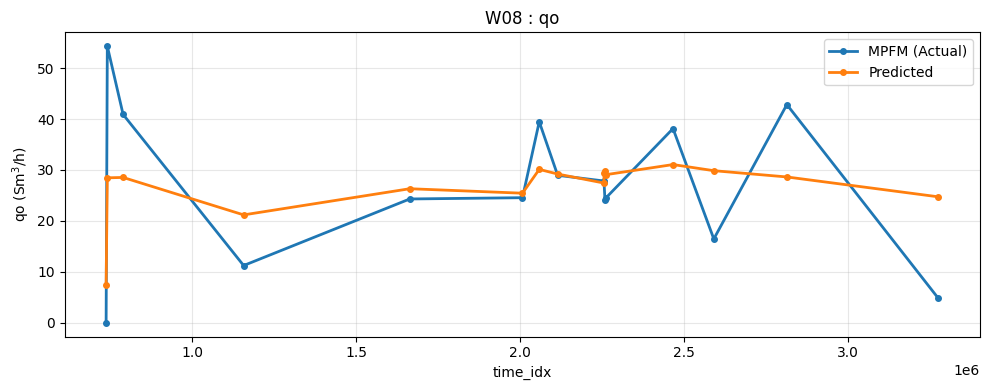

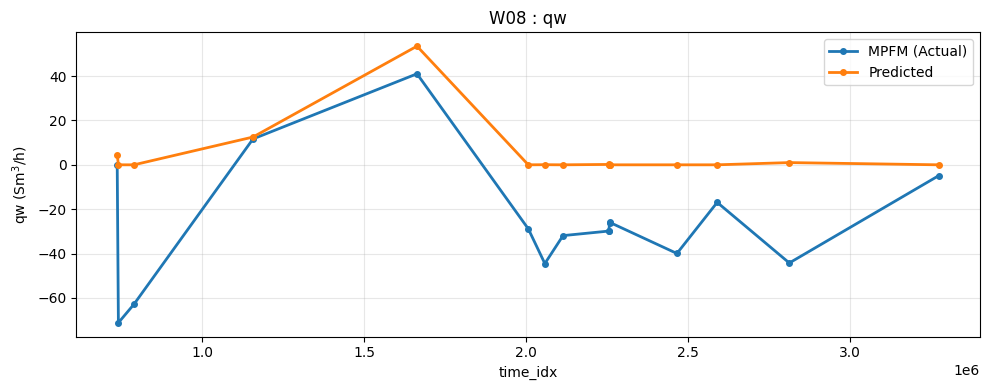

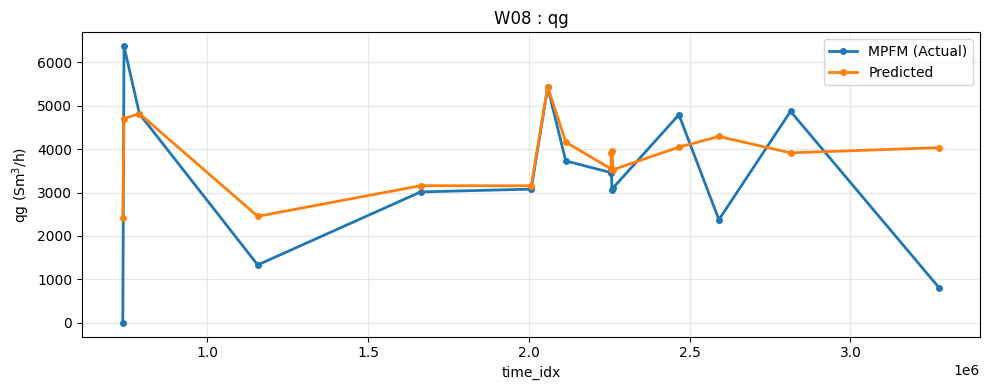

In [66]:
model.plot_predictions(df=df_test, time_col="time_idx", is_hybrid_model=True)

In [67]:
def lowo_with_partial_calibration(
    df,
    n_calibration_points=2,
):
    results = []

    for test_well in df["well_id"].unique():
        df_well = df[df["well_id"] == test_well]
        df_train_other = df[df["well_id"] != test_well]

        df_cal = df_well.iloc[:n_calibration_points]
        df_test = df_well.iloc[n_calibration_points:]

        df_train = pd.concat([df_train_other, df_cal])

        model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
        # model.phys_model.fit_pres = False
        model.fit(df_train)

        results.append({
            "well": test_well,
            "scores": model.hybrid_score(df_test)
        })

    return results


In [68]:
# lowo_with_partial_calibration(df=df_with_targets)